In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("segment_sleep_stress_features.csv")
df.head()

,Mean RR,SDNN,RMSSD,LF,HF,LF/HF,Label,Patient_ID,Segment
0,900.000000,59.518268,42.679485,71878.983711,75186.393033,0.956011,no_stress,a01,0
1,838.714286,46.041020,39.213278,69292.988384,40916.964752,1.693503,no_stress,a01,1
2,811.643836,80.085805,41.899350,70802.963147,55481.276868,1.276160,no_stress,a01,2
3,748.227848,61.144351,29.351975,60865.763438,25861.026522,2.353571,no_stress,a01,3
4,794.666667,46.168773,29.683010,86142.111093,24286.609088,3.546897,no_stress,a01,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17068 entries, 0 to 17067
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean RR     17030 non-null  float64
 1   SDNN        17030 non-null  float64
 2   RMSSD       17025 non-null  float64
 3   LF          17030 non-null  float64
 4   HF          17030 non-null  float64
 5   LF/HF       17030 non-null  float64
 6   Label       17068 non-null  object 
 7   Patient_ID  17068 non-null  object 
 8   Segment     17068 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
df.isnull().sum()

Mean RR       38
SDNN          38
RMSSD         43
LF            38
HF            38
LF/HF         38
Label          0
Patient_ID     0
Segment        0
dtype: int64

In [5]:
df.describe()

,Mean RR,SDNN,RMSSD,LF,HF,LF/HF,Segment
count,17030.000000,17030.000000,17025.000000,1.703000e+04,1.703000e+04,17030.000000,17068.000000
mean,935.530803,106.807938,107.104580,9.452676e+05,8.999030e+05,2.814303,244.443286
std,147.035314,203.252881,301.064746,7.094766e+07,7.546887e+06,4.617087,142.692392
min,471.666667,0.000000,7.254763,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,839.295775,35.787841,21.358005,1.218856e+04,7.190457e+03,0.527978,121.000000
50%,929.134425,64.112815,38.247918,3.733633e+04,2.477167e+04,1.357684,243.000000
75%,1010.508475,109.424409,79.882727,1.196560e+05,9.841148e+04,3.220415,365.000000
max,4244.285714,12404.489230,18932.658597,9.247768e+09,6.038403e+08,89.884771,576.000000


In [6]:
df.dropna(inplace=True)
df.isnull().sum()

Mean RR       0
SDNN          0
RMSSD         0
LF            0
HF            0
LF/HF         0
Label         0
Patient_ID    0
Segment       0
dtype: int64

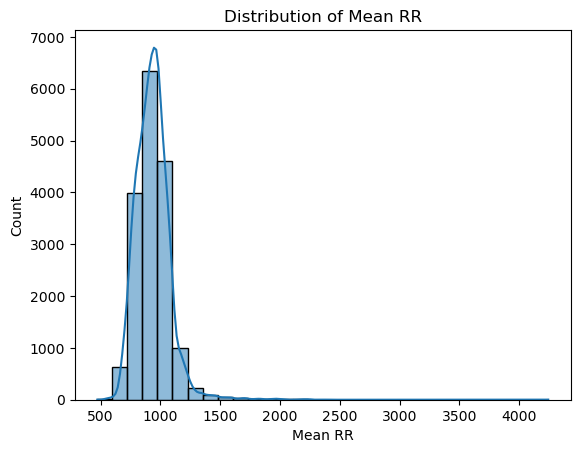

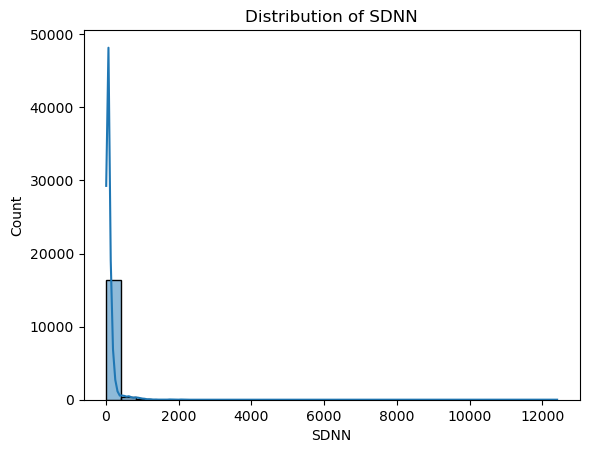

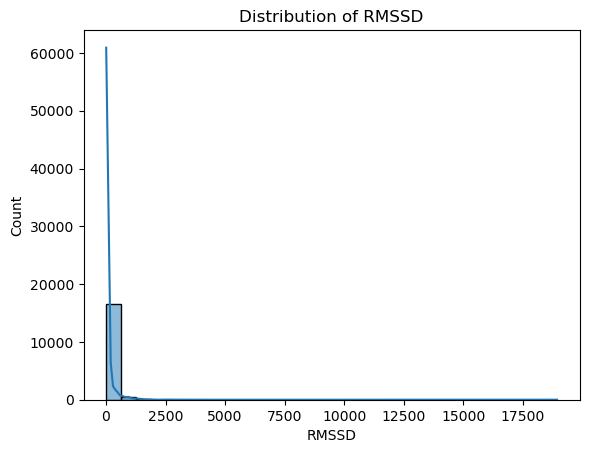

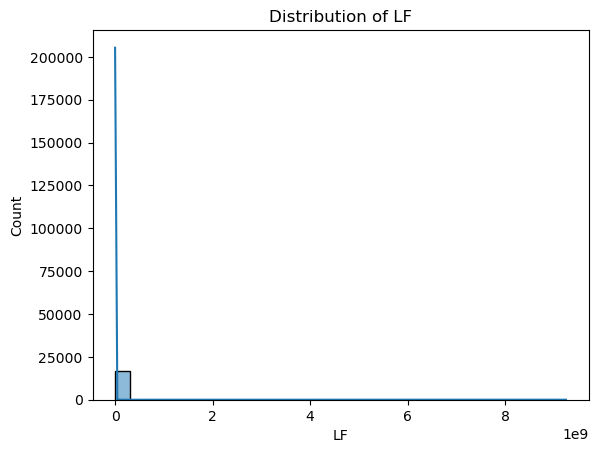

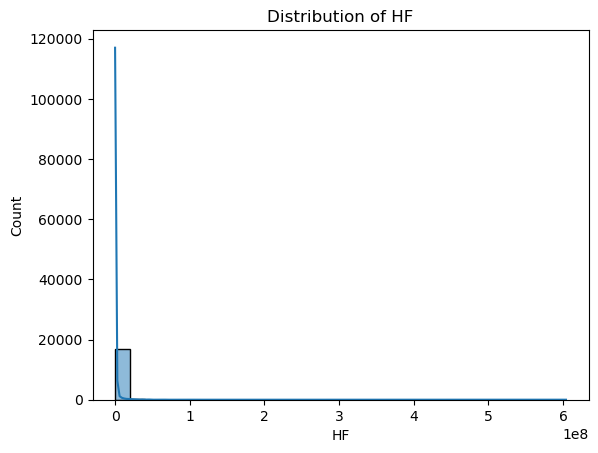

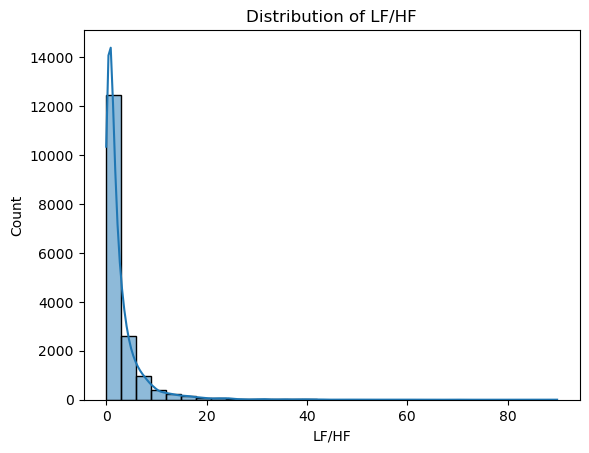

In [7]:
# Distribution of HRV features
for col in ['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


In [8]:
from scipy.stats import f_oneway

# Function to perform ANOVA for each numerical feature
def perform_anova(df, feature_cols, target_col):
    results = {}
    for feature in feature_cols:
        groups = [df[df[target_col] == label][feature] for label in df[target_col].unique()]
        f_stat, p_value = f_oneway(*groups)
        results[feature] = {'F-statistic': f_stat, 'P-value': p_value}
    return results

# Features to test and target column
feature_columns = ['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']
anova_results = perform_anova(df, feature_columns, target_col='Label')

# Display results
for feature, stats in anova_results.items():
    print(f"{feature}: F-statistic = {stats['F-statistic']:.2f}, P-value = {stats['P-value']:.4f}")


Mean RR: F-statistic = 42.60, P-value = 0.0000
SDNN: F-statistic = 207.33, P-value = 0.0000
RMSSD: F-statistic = 22.88, P-value = 0.0000
LF: F-statistic = 0.20, P-value = 0.6569
HF: F-statistic = 12.92, P-value = 0.0003
LF/HF: F-statistic = 474.56, P-value = 0.0000


Interpretation

P-value < 0.05: The feature has a statistically significant relationship with the label.

P-value >= 0.05: No significant difference between the means of the feature across the label categories.

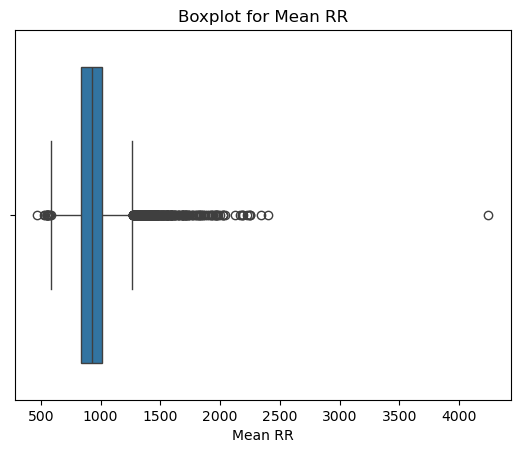

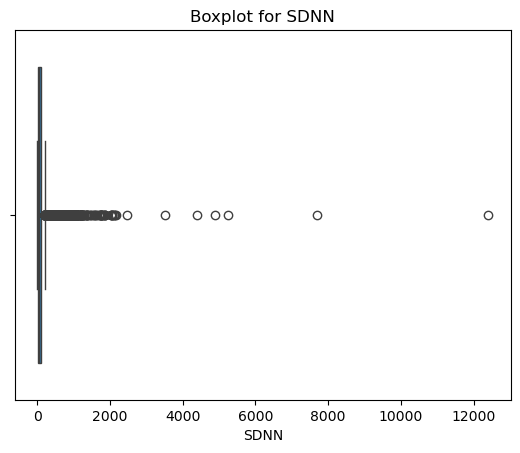

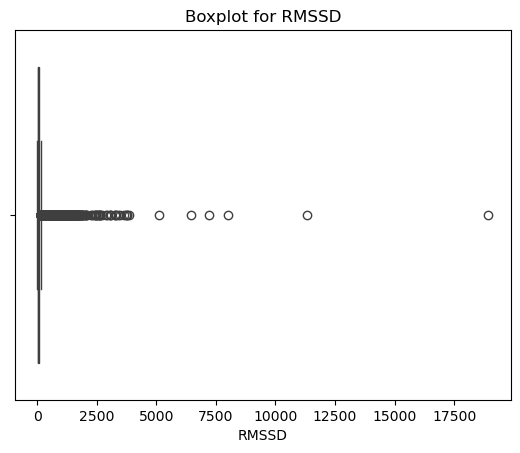

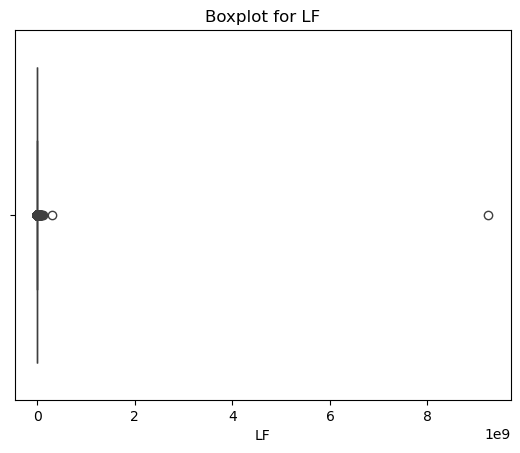

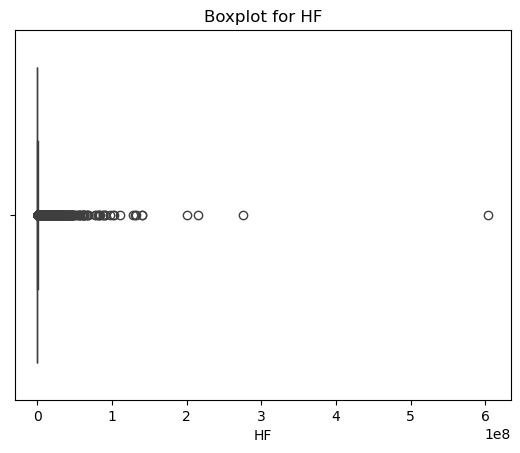

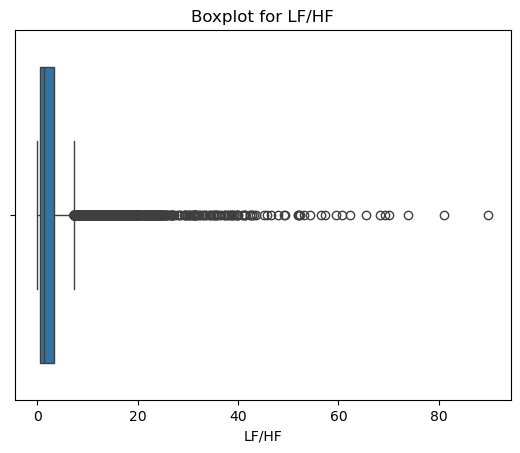

In [9]:
# Boxplot to detect outliers
for col in ['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# Optional: Remove outliers (e.g., values > 3 standard deviations)
from scipy.stats import zscore
df = df[(np.abs(zscore(df[['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']])) < 3).all(axis=1)]


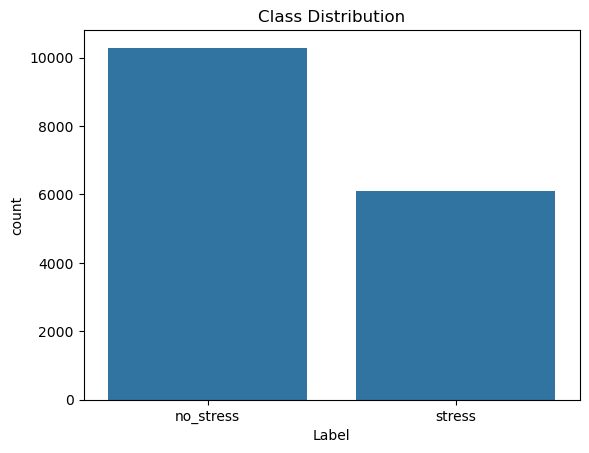

Label
no_stress    62.769982
stress       37.230018
Name: proportion, dtype: float64


In [10]:
# Class distribution
sns.countplot(x='Label', data=df)
plt.title("Class Distribution")
plt.show()

# Percentage distribution
print(df['Label'].value_counts(normalize=True) * 100)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [23]:
# Features and target variable
X = df[['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']]
y = df['Label']
# Encode the labels as 0 for 'no_stress' and 1 for 'stress'
y = y.map({'no_stress': 0, 'stress': 1})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler to scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# --- 1. Random Forest Classifier ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
rf_pred = rf_model.predict(X_test_scaled)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

Random Forest Classifier:
Accuracy: 0.7702867602196461
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2029
           1       0.71      0.67      0.69      1249

    accuracy                           0.77      3278
   macro avg       0.76      0.75      0.75      3278
weighted avg       0.77      0.77      0.77      3278



In [24]:
# --- 2. XGBoost Classifier ---
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
xgb_pred = xgb_model.predict(X_test_scaled)
print("\nXGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))


XGBoost Classifier:
Accuracy: 0.7632702867602197
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2029
           1       0.70      0.66      0.68      1249

    accuracy                           0.76      3278
   macro avg       0.75      0.74      0.75      3278
weighted avg       0.76      0.76      0.76      3278



In [26]:
# --- 3. Logistic Regression with L1 Regularization ---
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
logreg_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
logreg_pred = logreg_model.predict(X_test_scaled)
print("\nLogistic Regression Classifier (L1 Regularization):")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))


Logistic Regression Classifier (L1 Regularization):
Accuracy: 0.7214765100671141
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2029
           1       0.70      0.47      0.56      1249

    accuracy                           0.72      3278
   macro avg       0.72      0.67      0.68      3278
weighted avg       0.72      0.72      0.71      3278



In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7, None],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, 
                              cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)

print("Best Random Forest parameters:", grid_search_rf.best_params_)
print("Best Random Forest score:", grid_search_rf.best_score_)

# Best model from Random Forest
best_rf_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest score: 0.7866070055046117


In [30]:

# --- 2. XGBoost Hyperparameter Tuning ---
xgb_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_dist, 
                                       n_iter=10, cv=cv, n_jobs=-1, verbose=1, 
                                       scoring='accuracy', random_state=42)
random_search_xgb.fit(X_train_scaled, y_train)

print("Best XGBoost parameters:", random_search_xgb.best_params_)
print("Best XGBoost score:", random_search_xgb.best_score_)

# Best model from XGBoost
best_xgb_model = random_search_xgb.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best XGBoost score: 0.7820302010641648


In [31]:
# --- 3. Logistic Regression Hyperparameter Tuning ---
logreg_param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear']  # Solver for small datasets
}

logreg_model = LogisticRegression(random_state=42)
grid_search_logreg = GridSearchCV(estimator=logreg_model, param_grid=logreg_param_grid, 
                                  cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_logreg.fit(X_train_scaled, y_train)

print("Best Logistic Regression parameters:", grid_search_logreg.best_params_)
print("Best Logistic Regression score:", grid_search_logreg.best_score_)

# Best model from Logistic Regression
best_logreg_model = grid_search_logreg.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Logistic Regression parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression score: 0.7301693957082699


In [32]:
# --- Evaluate the best models on the test set ---

# Random Forest evaluation
rf_pred = best_rf_model.predict(X_test_scaled)
print("\nRandom Forest Test Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# XGBoost evaluation
xgb_pred = best_xgb_model.predict(X_test_scaled)
print("\nXGBoost Test Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# Logistic Regression evaluation
logreg_pred = best_logreg_model.predict(X_test_scaled)
print("\nLogistic Regression Test Accuracy:", accuracy_score(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))


Random Forest Test Accuracy: 0.7699816961561928
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      2029
           1       0.71      0.67      0.69      1249

    accuracy                           0.77      3278
   macro avg       0.76      0.75      0.75      3278
weighted avg       0.77      0.77      0.77      3278


XGBoost Test Accuracy: 0.7690665039658329
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2029
           1       0.71      0.67      0.69      1249

    accuracy                           0.77      3278
   macro avg       0.76      0.75      0.75      3278
weighted avg       0.77      0.77      0.77      3278


Logistic Regression Test Accuracy: 0.7236119585112873
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2029
           1       0.71      0.47      0.56      1249

    accuracy                       

In [33]:
import pickle

In [34]:
# Save the best Random Forest model
with open('best_rf_model.pkl', 'wb') as rf_file:
    pickle.dump(best_rf_model, rf_file)

# Save the best XGBoost model
with open('best_xgb_model.pkl', 'wb') as xgb_file:
    pickle.dump(best_xgb_model, xgb_file)

print("Models have been saved.")

Models have been saved.


# trying winzorize

In [39]:
from scipy import stats

df = pd.read_csv("segment_sleep_stress_features.csv")
df.head()

# Define the Winsorization limits (e.g., 5th and 95th percentiles)
df['Mean RR'] = stats.mstats.winsorize(df['Mean RR'], limits=[0.05, 0.05])
df['SDNN'] = stats.mstats.winsorize(df['SDNN'], limits=[0.05, 0.05])
df['RMSSD'] = stats.mstats.winsorize(df['RMSSD'], limits=[0.05, 0.05])
df['LF'] = stats.mstats.winsorize(df['LF'], limits=[0.05, 0.05])
df['HF'] = stats.mstats.winsorize(df['HF'], limits=[0.05, 0.05])
df['LF/HF'] = stats.mstats.winsorize(df['LF/HF'], limits=[0.05, 0.05])

# View the transformed DataFrame
df.head()

,Mean RR,SDNN,RMSSD,LF,HF,LF/HF,Label,Patient_ID,Segment
0,900.000000,59.518268,42.679485,71878.983711,75186.393033,0.956011,no_stress,a01,0
1,838.714286,46.041020,39.213278,69292.988384,40916.964752,1.693503,no_stress,a01,1
2,811.643836,80.085805,41.899350,70802.963147,55481.276868,1.276160,no_stress,a01,2
3,748.227848,61.144351,29.351975,60865.763438,25861.026522,2.353571,no_stress,a01,3
4,794.666667,46.168773,29.683010,86142.111093,24286.609088,3.546897,no_stress,a01,4


In [40]:
# Features and target variable
X = df[['Mean RR', 'SDNN', 'RMSSD', 'LF', 'HF', 'LF/HF']]
y = df['Label']
# Encode the labels as 0 for 'no_stress' and 1 for 'stress'
y = y.map({'no_stress': 0, 'stress': 1})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler to scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [45]:
# Step 5: Model training and evaluation
# Initialize models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
mlp = MLPClassifier(random_state=42)

# Cross-validation and evaluation for Random Forest, XGBoost, and MLP

# 5.1 Random Forest
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest Accuracy (CV): {rf_scores.mean():.4f}")

# 5.2 XGBoost
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost Accuracy (CV): {xgb_scores.mean():.4f}")

# 5.3 MLP
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=5, scoring='accuracy')
print(f"MLP Accuracy (CV): {mlp_scores.mean():.4f}")

Random Forest Accuracy (CV): 0.7694
XGBoost Accuracy (CV): 0.7657
MLP Accuracy (CV): 0.5606


In [46]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_grid_search.best_params_}")

Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [47]:
# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
}
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_grid_search.best_params_}")

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [48]:
# MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}
mlp_grid_search = GridSearchCV(mlp, mlp_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
mlp_grid_search.fit(X_train, y_train)
print(f"Best MLP Params: {mlp_grid_search.best_params_}")

Best MLP Params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [49]:
# Random Forest
rf_best = rf_grid_search.best_estimator_
rf_best.fit(X_train, y_train)
rf_pred = rf_best.predict(X_test)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Classification Report for RF:\n{classification_report(y_test, rf_pred)}")

# XGBoost
xgb_best = xgb_grid_search.best_estimator_
xgb_best.fit(X_train, y_train)
xgb_pred = xgb_best.predict(X_test)
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Classification Report for XGBoost:\n{classification_report(y_test, xgb_pred)}")

# MLP
mlp_best = mlp_grid_search.best_estimator_
mlp_best.fit(X_train, y_train)
mlp_pred = mlp_best.predict(X_test)
print(f"MLP Test Accuracy: {accuracy_score(y_test, mlp_pred):.4f}")
print(f"Classification Report for MLP:\n{classification_report(y_test, mlp_pred)}")

Random Forest Test Accuracy: 0.7762
Classification Report for RF:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2105
           1       0.73      0.67      0.70      1309

    accuracy                           0.78      3414
   macro avg       0.76      0.76      0.76      3414
weighted avg       0.77      0.78      0.77      3414

XGBoost Test Accuracy: 0.7815
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2105
           1       0.72      0.70      0.71      1309

    accuracy                           0.78      3414
   macro avg       0.77      0.77      0.77      3414
weighted avg       0.78      0.78      0.78      3414

MLP Test Accuracy: 0.6470
Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      2105
           1       0.55      0.42      0.48      

In [50]:
# Step 6: Export the model using Pickle with a 'winsorized' tag
model_filename = "xgb_winsorized_model.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(xgb, model_file)

print(f"XGBoost model with Winsorization has been exported to {model_filename}")

XGBoost model with Winsorization has been exported to xgb_winsorized_model.pkl
